In [1]:
import gc
import numpy as np
import pandas as pd
import lightgbm as lgbm
import category_encoders as ce
import matplotlib.pyplot as plt

from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, GradientBoostingRegressor
import xgboost as xgb

from sklearn.model_selection import train_test_split

from joblib import dump, load

np.random.seed(2024)

DATA_DIR = r'/Users/ahmadashfaq/Stock-Volatility-Prediction-/optiver-realized-volatility-prediction'

In [2]:
df_train_raw = pd.read_csv(f'{DATA_DIR}/train.csv')
df_test_raw = pd.read_csv(f'{DATA_DIR}/test.csv')

In [3]:
def calc_log_ret(prices):
    x = np.log(prices)
    return np.diff(x, prepend=[x[0]])

In [4]:
def book_preprocess(file_path):
    
    df = pd.read_parquet(file_path)
    
    df['wap1'] = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1'])/(df['bid_size1'] + df['ask_size1'])
    df['log_ret1'] = df.groupby('time_id')['wap1'].transform(lambda x: calc_log_ret(x.to_numpy())) # Each time_id is a window having several time stamps
    
    df['wap2'] = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2'])/(df['bid_size2'] + df['ask_size2'])
    df['log_ret2'] = df.groupby('time_id')['wap2'].transform(lambda x: calc_log_ret(x.to_numpy())) # Each time_id is a window having several time stamps
    
    df['wap_balance'] = df['wap1'] - df['wap2']
    
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']))
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    
    df['total_volume'] = df['ask_size1'] + df['ask_size2'] + df['bid_size1'] + df['bid_size2']
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))
    
    # Mid Price Change
    df['mid_price'] = (df['bid_price1'] + df['ask_price1']) / 2
    df['mid_price_change'] = df.groupby('time_id')['mid_price'].transform(lambda x: x.diff())
    
    
    df['avg_bid_ask_spread'] = (df['ask_price1'] - df['bid_price1']) / (df['ask_price1'] + df['bid_price1'])
    df['bid_ask_spread_volatility'] = df.groupby('time_id')['avg_bid_ask_spread'].transform('std')

    # Rolling Volatility for WAP1 and WAP2
    df['rolling_volatility_wap1'] = df.groupby('time_id')['log_ret1'].transform(lambda x: x.rolling(window=30).std())
    df['rolling_volatility_wap2'] = df.groupby('time_id')['log_ret2'].transform(lambda x: x.rolling(window=30).std())
    
    # Liquidity Measures - Depth Ratio
    df['depth_ratio'] = (df['bid_size1'] + df['bid_size2']) / (df['ask_size1'] + df['ask_size2'])
    
    # Skewness and Kurtosis
    df['log_ret1_skew'] = df.groupby('time_id')['log_ret1'].transform('skew')
    df['log_ret2_skew'] = df.groupby('time_id')['log_ret2'].transform('skew')
    
    df['price_spread_skew'] = df.groupby('time_id')['price_spread'].transform('skew')
    df['volume_imbalance_skew'] = df.groupby('time_id')['volume_imbalance'].transform('skew')
    

    
    # VWAP Calculation
    df['vwap'] = (df['bid_price1'] * df['bid_size1'] + df['ask_price1'] * df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
    
    create_feature_dict = {
        'log_ret1': ['std'],
        'log_ret2': ['std'],
        'wap_balance': ['mean', 'std'],
        'price_spread': ['mean', 'std'],
        'bid_spread': ['mean', 'std'],
        'ask_spread': ['mean', 'std'],
        'volume_imbalance': ['mean', 'std'],
        'total_volume': ['mean', 'std'],
        'wap1': ['mean', 'std'],
        'wap2': ['mean', 'std'],
        'vwap':['mean', "std"],
        'rolling_volatility_wap2':["mean", "std"],
        'rolling_volatility_wap1':["mean", "std"],
        'log_ret1_skew':["mean"],
        'log_ret2_skew':['mean'],
        'volume_imbalance_skew':['mean'],
        'price_spread_skew':['mean']
    }
    
    df_feature = pd.DataFrame(
        df.groupby(['time_id']).agg(create_feature_dict)
    ).reset_index()
    df_feature.columns = ['_'.join(col) if col[0] != 'time_id' else col[0] for col in df_feature.columns]
    
    last_seconds = [300, 120]
    for second in last_seconds:
        df_feature_sec = pd.DataFrame(
            df[df['seconds_in_bucket'] >= 600 - second]
        ).groupby(['time_id']).agg(create_feature_dict).reset_index()
        df_feature_sec.columns = ['_'.join(col) if col[0] != 'time_id' else col[0] for col in df_feature_sec.columns]
        df_feature_sec = df_feature_sec.add_suffix(f'_{second}')
        
        df_feature = pd.merge(
            df_feature, df_feature_sec,
            how='left', left_on='time_id',right_on=f'time_id_{second}'
        )
        df_feature.drop([f'time_id_{second}'], axis=1, inplace=True)
    
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = str(stock_id) + '-' + df_feature['time_id'].astype(str)
    df_feature.drop(['time_id'], axis=1, inplace=True)
    
    return df_feature

In [5]:
book_preprocess(f'{DATA_DIR}/book_train.parquet/stock_id=0').head(5)

,log_ret1_std,log_ret2_std,wap_balance_mean,wap_balance_std,price_spread_mean,price_spread_std,bid_spread_mean,bid_spread_std,ask_spread_mean,ask_spread_std,...,vwap_std_120,rolling_volatility_wap2_mean_120,rolling_volatility_wap2_std_120,rolling_volatility_wap1_mean_120,rolling_volatility_wap1_std_120,log_ret1_skew_mean_120,log_ret2_skew_mean_120,volume_imbalance_skew_mean_120,price_spread_skew_mean_120,row_id
0,0.000259,0.000403,0.000065,0.000484,0.000852,0.000211,0.000176,0.000162,-0.000151,0.000126,...,0.000583,0.000445,0.000106,0.000199,0.000031,0.333550,0.302634,0.973341,0.140945,0-5
1,0.000085,0.000175,0.000033,0.000261,0.000394,0.000157,0.000142,0.000148,-0.000135,0.000065,...,0.000276,0.000238,0.000033,0.000084,0.000027,-1.106416,0.294099,0.752084,1.113890,0-11
2,0.000173,0.000351,-0.000138,0.000389,0.000725,0.000164,0.000197,0.000170,-0.000198,0.000171,...,0.000425,0.000354,0.000061,0.000175,0.000019,-0.194037,-0.453121,0.838349,0.204095,0-16
3,0.000235,0.000333,0.000199,0.000409,0.000860,0.000280,0.000190,0.000199,-0.000108,0.000091,...,0.000159,0.000437,0.000030,0.000281,0.000018,-1.974680,-1.368015,1.137728,0.339405,0-31
4,0.000143,0.000246,-0.000008,0.000317,0.000397,0.000130,0.000191,0.000083,-0.000109,0.000076,...,0.000161,0.000198,0.000035,0.000179,0.000025,0.456073,0.118453,0.658649,0.609004,0-62


In [6]:
def trade_preprocess(file_path):
    df = pd.read_parquet(file_path)
    df['log_ret'] = df.groupby('time_id')['price'].transform(lambda x: calc_log_ret(x.to_numpy())) # Each time_id is a window having several time stamps
    
    aggregate_dictionary = {
        'log_ret': ['std'],
        'size': ['sum', 'mean', 'std'],
        'order_count': ['sum', 'mean', 'std'],
    }
    df_feature = df.groupby('time_id').agg(aggregate_dictionary).reset_index()
    df_feature.columns = ['_'.join(col) if col[0] != 'time_id' else col[0] for col in df_feature.columns]
    
    last_seconds = [300, 120]
    for second in last_seconds:
        df_feature_sec = pd.DataFrame(
            df[df['seconds_in_bucket'] >= 600 - second]
        ).groupby(['time_id']).agg(aggregate_dictionary).reset_index()
        df_feature_sec.columns = ['_'.join(col) if col[0] != 'time_id' else col[0] for col in df_feature_sec.columns]
        df_feature_sec = df_feature_sec.add_suffix(f'_{second}')
        
        df_feature = pd.merge(
            df_feature, df_feature_sec,
            how='left', left_on='time_id',right_on=f'time_id_{second}'
        )
        df_feature.drop([f'time_id_{second}'], axis=1, inplace=True)
    
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = str(stock_id) + '-' + df_feature['time_id'].astype(str)
    df_feature.drop(['time_id'], axis=1, inplace=True)
    
    return df_feature

In [7]:
trade_preprocess(f'{DATA_DIR}/trade_train.parquet/stock_id=0').head(5)

,log_ret_std,size_sum,size_mean,size_std,order_count_sum,order_count_mean,order_count_std,log_ret_std_300,size_sum_300,size_mean_300,...,order_count_mean_300,order_count_std_300,log_ret_std_120,size_sum_120,size_mean_120,size_std_120,order_count_sum_120,order_count_mean_120,order_count_std_120,row_id
0,0.000319,3179,79.475000,118.375107,110,2.750000,2.467741,0.000290,1587.0,75.571429,...,2.571429,2.292846,0.000314,739.0,67.181818,149.948537,27.0,2.454545,1.752920,0-5
1,0.000165,1289,42.966667,77.815203,57,1.900000,1.446756,0.000151,900.0,56.250000,...,2.250000,1.807392,0.000181,826.0,103.250000,111.347269,20.0,2.500000,2.267787,0-11
2,0.000387,2161,86.440000,113.587000,68,2.720000,2.300725,0.000275,1189.0,99.083333,...,3.166667,2.691175,0.000305,681.0,97.285714,112.658354,17.0,2.428571,1.812654,0-16
3,0.000387,1962,130.800000,144.828569,59,3.933333,4.043808,0.000381,1556.0,172.888889,...,5.111111,4.702245,0.000202,509.0,254.500000,276.478751,10.0,5.000000,4.242641,0-31
4,0.000190,1791,81.409091,117.914682,89,4.045455,4.099678,0.000143,1219.0,110.818182,...,4.909091,4.887833,0.000206,43.0,10.750000,15.585784,14.0,3.500000,4.358899,0-62


In [8]:
def preprocessor(stock_id_list, train_mode = True):
    
    from joblib import Parallel, delayed # parallel computing to save time
    
    df = pd.DataFrame()
    
    def for_joblib(stock_id):
        if train_mode:
            file_path_book = f'{DATA_DIR}/book_train.parquet/stock_id={stock_id}'
            file_path_trade = f'{DATA_DIR}/trade_train.parquet/stock_id={stock_id}'
        else:
            file_path_book = f'{DATA_DIR}/book_test.parquet/stock_id={stock_id}'
            file_path_trade = f'{DATA_DIR}/trade_test.parquet/stock_id={stock_id}'
            
        df_tmp = pd.merge(
            book_preprocess(file_path_book),
            trade_preprocess(file_path_trade),
            on='row_id', how='left'
        )
        return pd.concat([df,df_tmp])
    
    df = Parallel(n_jobs=-1, verbose=1)(
            delayed(for_joblib)(stock_id) for stock_id in stock_id_list
        )

    df =  pd.concat(df, ignore_index = True)
    return df

In [9]:
# Data loading and preprocessing
df_train_raw = pd.read_csv(f'{DATA_DIR}/train.csv')
df_test_raw = pd.read_csv(f'{DATA_DIR}/test.csv')

train_stock_id_list = df_train_raw['stock_id'].unique()
df_train = preprocessor(train_stock_id_list, train_mode=True)
df_train = pd.merge(df_train, 
                   df_train_raw.assign(row_id=lambda x: x['stock_id'].astype(str) + '-' + x['time_id'].astype(str))[['row_id', 'target', 'time_id']],  # Include 'time_id'
                   on='row_id', how='right')
df_train['stock_id'] = df_train['row_id'].str.split('-').str[0].astype('category')
df_train['time_id'] = df_train['time_id'].astype(int)  # Ensure it's int
df_train.drop(['row_id'], axis=1, inplace=True)

test_stock_id_list = df_test_raw['stock_id'].unique()
df_test = preprocessor(test_stock_id_list, train_mode=False)
df_test = pd.merge(df_test, 
                  df_test_raw.assign(row_id=lambda x: x['stock_id'].astype(str) + '-' + x['time_id'].astype(str))[['row_id', 'time_id']],  # Include 'time_id'
                  on='row_id', how='right')
df_test['stock_id'] = df_test['row_id'].str.split('-').str[0].astype('category')
df_test['time_id'] = df_test['time_id'].astype(int)  # Ensure it's int
df_test.drop(['row_id'], axis=1, inplace=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  1.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [10]:
# Data preparation with median imputation
X_train = df_train.drop(['target'], axis=1)
Y_train = df_train['target']
X_test_sub = df_test

In [11]:
# Target encoding
t_encoder = ce.TargetEncoder(smoothing=10)
X_train['stock_id'] = t_encoder.fit_transform(X_train['stock_id'], Y_train)
X_test_sub['stock_id'] = t_encoder.transform(X_test_sub['stock_id'])

In [12]:
X_train

,log_ret1_std,log_ret2_std,wap_balance_mean,wap_balance_std,price_spread_mean,price_spread_std,bid_spread_mean,bid_spread_std,ask_spread_mean,ask_spread_std,...,order_count_std_300,log_ret_std_120,size_sum_120,size_mean_120,size_std_120,order_count_sum_120,order_count_mean_120,order_count_std_120,time_id,stock_id
0,0.000259,0.000403,0.000065,0.000484,0.000852,0.000211,0.000176,0.000162,-0.000151,0.000126,...,2.292846,0.000314,739.0,67.181818,149.948537,27.0,2.454545,1.752920,5,0.004028
1,0.000085,0.000175,0.000033,0.000261,0.000394,0.000157,0.000142,0.000148,-0.000135,0.000065,...,1.807392,0.000181,826.0,103.250000,111.347269,20.0,2.500000,2.267787,11,0.004028
2,0.000173,0.000351,-0.000138,0.000389,0.000725,0.000164,0.000197,0.000170,-0.000198,0.000171,...,2.691175,0.000305,681.0,97.285714,112.658354,17.0,2.428571,1.812654,16,0.004028
3,0.000235,0.000333,0.000199,0.000409,0.000860,0.000280,0.000190,0.000199,-0.000108,0.000091,...,4.702245,0.000202,509.0,254.500000,276.478751,10.0,5.000000,4.242641,31,0.004028
4,0.000143,0.000246,-0.000008,0.000317,0.000397,0.000130,0.000191,0.000083,-0.000109,0.000076,...,4.887833,0.000206,43.0,10.750000,15.585784,14.0,3.500000,4.358899,62,0.004028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428927,0.000210,0.000334,-0.000003,0.000453,0.000878,0.000235,0.000091,0.000115,-0.000202,0.000164,...,1.392088,0.000357,159.0,17.666667,32.260657,15.0,1.666667,1.000000,32751,0.005321
428928,0.000275,0.000334,-0.000126,0.000352,0.000706,0.000228,0.000126,0.000132,-0.000142,0.000136,...,3.831655,0.000339,321.0,32.100000,61.156357,19.0,1.900000,0.994429,32753,0.005321
428929,0.000195,0.000377,0.000086,0.000492,0.000739,0.000240,0.000189,0.000198,-0.000192,0.000118,...,1.955575,0.000608,130.0,43.333333,65.683585,8.0,2.666667,2.886751,32758,0.005321
428930,0.000184,0.000269,0.000019,0.000290,0.000530,0.000172,0.000143,0.000116,-0.000134,0.000100,...,2.280934,0.000175,1284.0,91.714286,95.347485,38.0,2.714286,2.554892,32763,0.005321


In [13]:
val_with_zero = X_train.isna().sum().sort_values(ascending=False)

val_with_zero[val_with_zero > 0]/X_train.shape[0]

order_count_std_120                 0.022400
size_std_120                        0.022400
log_ret_std_120                     0.022400
order_count_mean_120                0.007150
order_count_sum_120                 0.007150
size_mean_120                       0.007150
size_sum_120                        0.007150
order_count_std_300                 0.001863
log_ret_std_300                     0.001863
size_std_300                        0.001863
order_count_sum_300                 0.000555
size_sum_300                        0.000555
size_mean_300                       0.000555
order_count_mean_300                0.000555
size_std                            0.000187
log_ret_std                         0.000187
order_count_std                     0.000187
size_sum                            0.000044
order_count_mean                    0.000044
order_count_sum                     0.000044
size_mean                           0.000044
rolling_volatility_wap2_std_120     0.000009
rolling_vo

In [14]:
val_with_zero  = df_test.isna().sum().sort_values(ascending=False)

val_with_zero [val_with_zero  > 0]/df_test.shape[0]

log_ret2_skew_mean_300        1.000000
total_volume_std_300          1.000000
wap_balance_std_120           1.000000
wap_balance_mean_120          1.000000
log_ret2_std_120              1.000000
                                ...   
vwap_mean                     0.666667
vwap_std                      0.666667
log_ret1_skew_mean            0.666667
log_ret2_skew_mean            0.666667
volume_imbalance_skew_mean    0.666667
Length: 105, dtype: float64

In [15]:
X_train.dropna(inplace=True)

In [16]:
X_train.isna().sum().sort_values(ascending=False)

log_ret1_std                        0
log_ret1_skew_mean_120              0
rolling_volatility_wap1_mean_120    0
rolling_volatility_wap2_std_120     0
rolling_volatility_wap2_mean_120    0
                                   ..
price_spread_mean_300               0
wap_balance_std_300                 0
wap_balance_mean_300                0
log_ret2_std_300                    0
stock_id                            0
Length: 107, dtype: int64

In [17]:
Y_train = Y_train[X_train.index]

In [18]:
# Median imputation
for col in X_train.columns:
    median_val = X_train[col].median()
    X_train[col] = X_train[col].fillna(median_val)
    X_test_sub[col] = X_test_sub[col].fillna(median_val)

# Time-based splitting
time_ids = X_train['time_id'].unique()
train_time_ids = time_ids[:int(0.8 * len(time_ids))]
val_time_ids = time_ids[int(0.8 * len(time_ids)):]

X_train_split = X_train[X_train['time_id'].isin(train_time_ids)]
y_train_split = Y_train[X_train_split.index]
X_val_split = X_train[X_train['time_id'].isin(val_time_ids)]
y_val_split = Y_train[X_val_split.index]

In [19]:
X_test_sub

,log_ret1_std,log_ret2_std,wap_balance_mean,wap_balance_std,price_spread_mean,price_spread_std,bid_spread_mean,bid_spread_std,ask_spread_mean,ask_spread_std,...,order_count_std_300,log_ret_std_120,size_sum_120,size_mean_120,size_std_120,order_count_sum_120,order_count_mean_120,order_count_std_120,time_id,stock_id
0,0.000170,0.000138,-1.451734e-04,0.000022,0.000557,0.000028,0.000393,0.000000,-0.000115,0.000113,...,3.059593,0.000233,2190.0,170.736842,172.787837,42.0,3.294118,2.753785,4,0.004028
1,0.000167,0.000229,3.159187e-07,0.000232,0.000439,0.000146,0.000161,0.000077,-0.000163,0.000078,...,3.059593,0.000233,2190.0,170.736842,172.787837,42.0,3.294118,2.753785,32,0.004028
2,0.000167,0.000229,3.159187e-07,0.000232,0.000439,0.000146,0.000161,0.000077,-0.000163,0.000078,...,3.059593,0.000233,2190.0,170.736842,172.787837,42.0,3.294118,2.753785,34,0.004028


In [21]:
def rmspe(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    return np.sqrt(np.mean(
            np.square(((y_true - y_pred) / y_true))
        ))

In [25]:
modelo1 = lgbm.LGBMRegressor(
                  colsample_bytree=0.1, max_bin=140, max_depth=6,
                  min_child_samples=360, min_child_weight=10.0, n_estimators=1260,
                  n_jobs=-1, num_leaves=80, objective='regression', reg_alpha=0.01,
                  reg_lambda=0.01, subsample=0.01,
                  random_state=2025
                  )

modelo2 = lgbm.LGBMRegressor(
                  colsample_bytree=0.1, max_bin=140, max_depth=12,
                  min_child_samples=360, min_child_weight=10.0, n_estimators=1260,
                  n_jobs=-1, num_leaves=50, objective='regression', reg_alpha=0.01,
                  reg_lambda=0.01, subsample=0.01,
                  random_state=234
                  )

modelo3 = lgbm.LGBMRegressor(
                  colsample_bytree=0.1, max_bin=140, max_depth=4,
                  min_child_samples=360, min_child_weight=10.0, n_estimators=1260,
                  n_jobs=-1, num_leaves=120, objective='regression', reg_alpha=0.01,
                  reg_lambda=0.01, subsample=0.01,
                  random_state=189
                  )


ensemble_voting = VotingRegressor(
    [
        ('md1', modelo1),
        ('md2', modelo2),
        ('md3', modelo3)
    ], weights = [3.0, 4.0, 5.0], verbose=False
).fit(X_train, y_train)

NameError: name 'y_train' is not defined

In [ ]:
Y_train_pred = ensemble_voting.predict(X_train)
rmspe(y_train.values, Y_train_pred)

0.25190619544618414

In [ ]:
Y_test_pred = ensemble_voting.predict(X_test_sub)
Y_test_pred

array([0.00153626, 0.00060371, 0.00060371])

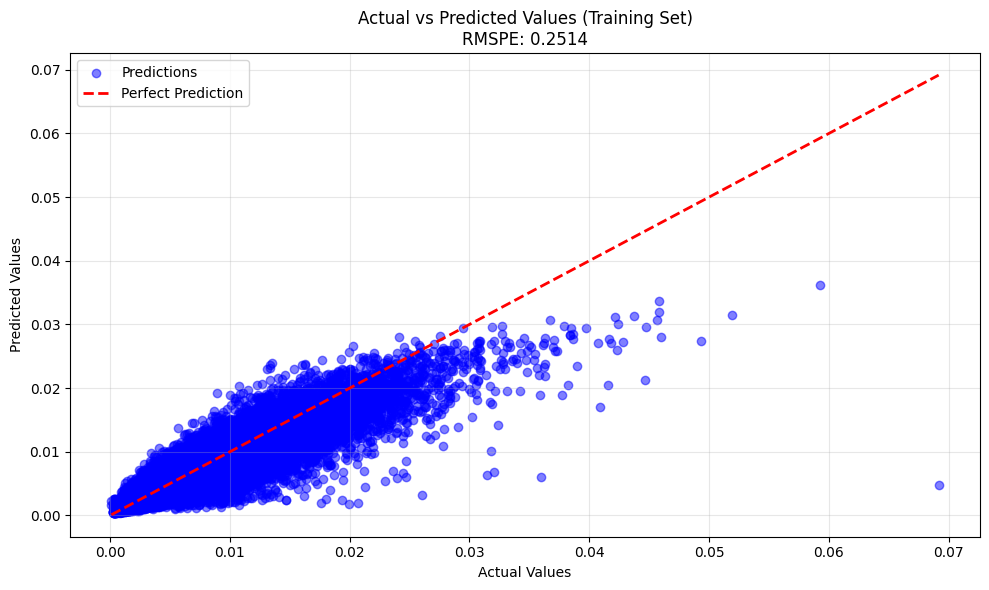

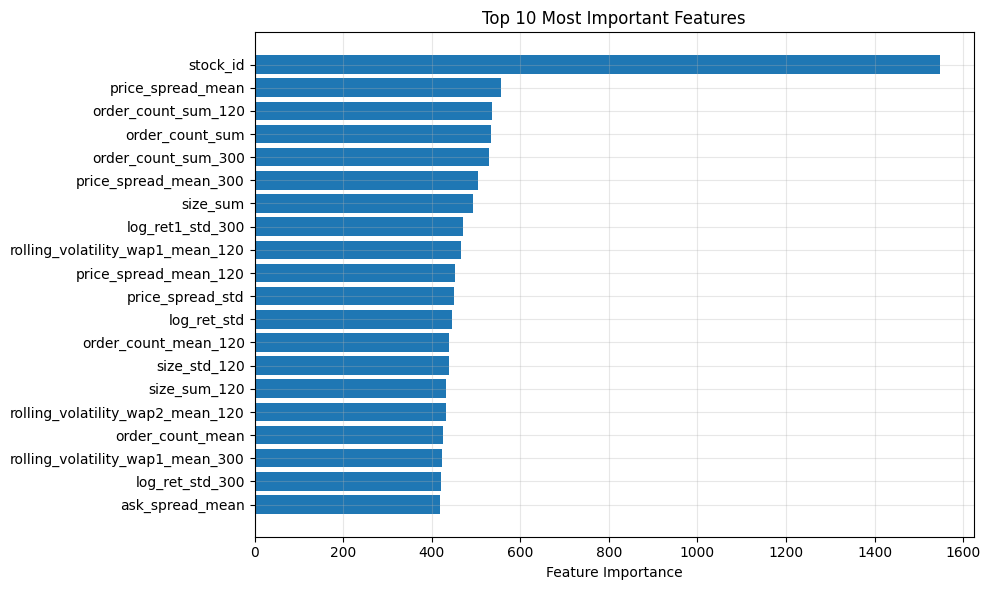

Root Mean Square Percentage Error (RMSPE): 0.2514
Mean Squared Error (MSE): 0.000001
Root Mean Square Error (RMSE): 0.001047


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Assuming these variables are available from your original code
# y_train: actual training targets
# Y_train_pred: predicted training targets
# ensemble_voting: trained VotingRegressor
# X_train: training features

# 1. Scatter Plot: Actual vs Predicted Values
plt.figure(figsize=(10, 6))
plt.scatter(y_train, Y_train_pred, alpha=0.5, c='blue', label='Predictions')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Training Set)\nRMSPE: {:.4f}'.format(
    rmspe(y_train.values, Y_train_pred)))
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('actual_vs_predicted.png')
plt.show()

# 2. Feature Importance Plot
# Access the fitted estimators from the VotingRegressor
fitted_estimators = ensemble_voting.named_estimators_

# Calculate mean feature importance across the three fitted LightGBM models
feature_importance = np.mean([
    fitted_estimators['md1'].feature_importances_,
    fitted_estimators['md2'].feature_importances_,
    fitted_estimators['md3'].feature_importances_
], axis=0)

# Get top 10 features
n_top_features = 20
sorted_idx = np.argsort(feature_importance)[::-1][:n_top_features]
top_features = X_train.columns[sorted_idx]
top_importance = feature_importance[sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(range(n_top_features), top_importance, align='center')
plt.yticks(range(n_top_features), top_features)
plt.xlabel('Feature Importance')
plt.title('Top 10 Most Important Features')
plt.gca().invert_yaxis()  # Highest importance at top
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

# Calculate and print additional metrics
mse = mean_squared_error(y_train, Y_train_pred)
rmse = np.sqrt(mse)

print(f"Root Mean Square Percentage Error (RMSPE): {rmspe(y_train.values, Y_train_pred):.4f}")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Square Error (RMSE): {rmse:.6f}")

# Define RMSPE function if not already defined
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true))))

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, explained_variance_score

# Calculate additional metrics
r2 = r2_score(y_train, Y_train_pred)
mae = mean_absolute_error(y_train, Y_train_pred)
explained_variance = explained_variance_score(y_train, Y_train_pred)

# Create a table of metrics
metrics = {
    'Metric': ['RMSPE', 'MSE', 'RMSE', 'R²', 'MAE', 'Explained Variance'],
    'Value': [
        rmspe(y_train.values, Y_train_pred),
        mse,
        rmse,
        r2,
        mae,
        explained_variance
    ]
}

# Display the table
metrics_df = pd.DataFrame(metrics)
print(metrics_df)


               Metric     Value
0               RMSPE  0.251362
1                 MSE  0.000001
2                RMSE  0.001047
3                  R²  0.872012
4                 MAE  0.000649
5  Explained Variance  0.872012


In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(ensemble_voting, X_train, y_train)

train_errors = np.mean(train_scores, axis=1)
val_errors = np.mean(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_errors, label='Training Error', color='blue')
plt.plot(train_sizes, val_errors, label='Validation Error', color='red')
plt.xlabel('Training Size')
plt.ylabel('Error (RMSE)')
plt.title('Learning Curves')
plt.legend()
plt.grid(True)
plt.show()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10613
[LightGBM] [Info] Number of data points in the train set: 26836, number of used features: 76
[LightGBM] [Info] Start training from score 0.003881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

Exception ignored on calling ctypes callback function: <function _log_callback at 0x168ec56c0>
Traceback (most recent call last):
  File "/Users/ahmadashfaq/pinokio/api/oobabooga.pinokio.git/text-generation-webui/installer_files/conda/lib/python3.10/site-packages/lightgbm/basic.py", line 257, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer
import numpy as np

def rmspe(y_true, y_pred):
    """
    Calculate Root Mean Square Percentage Error
    Args:
        y_true: array-like of true values
        y_pred: array-like of predicted values
    Returns:
        float: RMSPE value
    """
    return np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true))))

    
# Define RMSPE scorer for learning curve
rmspe_scorer = make_scorer(rmspe, greater_is_better=False)

# Calculate learning curves
train_sizes, train_scores, val_scores = learning_curve(
    ensemble_voting,
    X_train,
    y_train,
    cv=5,  # 5-fold cross-validation
    scoring=rmspe_scorer,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10 points from 10% to 100% of training data
    random_state=2024
)

# Calculate mean and standard deviation of scores
train_mean = -np.mean(train_scores, axis=1)  # Negate because scorer returns negative values
train_std = np.std(train_scores, axis=1)
val_mean = -np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Create the learning curve plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 
         label='Training RMSPE',
         marker='o',
         color='blue')
plt.plot(train_sizes, val_mean, 
         label='Validation RMSPE',
         marker='o',
         color='red')

# Add fill between for standard deviation
plt.fill_between(train_sizes,
                 train_mean - train_std,
                 train_mean + train_std,
                 alpha=0.1,
                 color='blue')
plt.fill_between(train_sizes,
                 val_mean - val_std,
                 val_mean + val_std,
                 alpha=0.1,
                 color='red')

# Customize the plot
plt.xlabel('Training Examples')
plt.ylabel('RMSPE (Root Mean Square Percentage Error)')
plt.title('Learning Curves: Training vs Validation RMSPE')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Add text box with final scores
final_train_rmspe = train_mean[-1]
final_val_rmspe = val_mean[-1]
text_box = f'Final Scores:\nTrain RMSPE: {final_train_rmspe:.4f}\nVal RMSPE: {final_val_rmspe:.4f}'
plt.text(0.95, 0.95, text_box,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Save and show the plot
plt.savefig('learning_curves_rmspe.png')
plt.show()

# Print additional diagnostics
print("Learning Curve Metrics:")
print(f"Number of training sizes evaluated: {len(train_sizes)}")
print(f"Final Training RMSPE: {final_train_rmspe:.4f} (±{train_std[-1]:.4f})")
print(f"Final Validation RMSPE: {final_val_rmspe:.4f} (±{val_std[-1]:.4f})")
print(f"Gap between final train and val RMSPE: {abs(final_train_rmspe - final_val_rmspe):.4f}")
import numpy as np

# Define RMSPE scorer for learning curve
rmspe_scorer = make_scorer(rmspe, greater_is_better=False)

# Calculate learning curves
train_sizes, train_scores, val_scores = learning_curve(
    ensemble_voting,
    X_train,
    y_train,
    scoring=rmspe_scorer,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10 points from 10% to 100% of training data
    random_state=2024
)

# Calculate mean and standard deviation of scores
train_mean = -np.mean(train_scores, axis=1)  # Negate because scorer returns negative values
train_std = np.std(train_scores, axis=1)
val_mean = -np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Create the learning curve plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 
         label='Training RMSPE',
         marker='o',
         color='blue')
plt.plot(train_sizes, val_mean, 
         label='Validation RMSPE',
         marker='o',
         color='red')

# Add fill between for standard deviation
plt.fill_between(train_sizes,
                 train_mean - train_std,
                 train_mean + train_std,
                 alpha=0.1,
                 color='blue')
plt.fill_between(train_sizes,
                 val_mean - val_std,
                 val_mean + val_std,
                 alpha=0.1,
                 color='red')

# Customize the plot
plt.xlabel('Training Examples')
plt.ylabel('RMSPE (Root Mean Square Percentage Error)')
plt.title('Learning Curves: Training vs Validation RMSPE')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Add text box with final scores
final_train_rmspe = train_mean[-1]
final_val_rmspe = val_mean[-1]
text_box = f'Final Scores:\nTrain RMSPE: {final_train_rmspe:.4f}\nVal RMSPE: {final_val_rmspe:.4f}'
plt.text(0.95, 0.95, text_box,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Save and show the plot
plt.savefig('learning_curves_rmspe.png')
plt.show()

# Print additional diagnostics
print("Learning Curve Metrics:")
print(f"Number of training sizes evaluated: {len(train_sizes)}")
print(f"Final Training RMSPE: {final_train_rmspe:.4f} (±{train_std[-1]:.4f})")
print(f"Final Validation RMSPE: {final_val_rmspe:.4f} (±{val_std[-1]:.4f})")
print(f"Gap between final train and val RMSPE: {abs(final_train_rmspe - final_val_rmspe):.4f}")

NameError: name 'ensemble_voting' is not defined

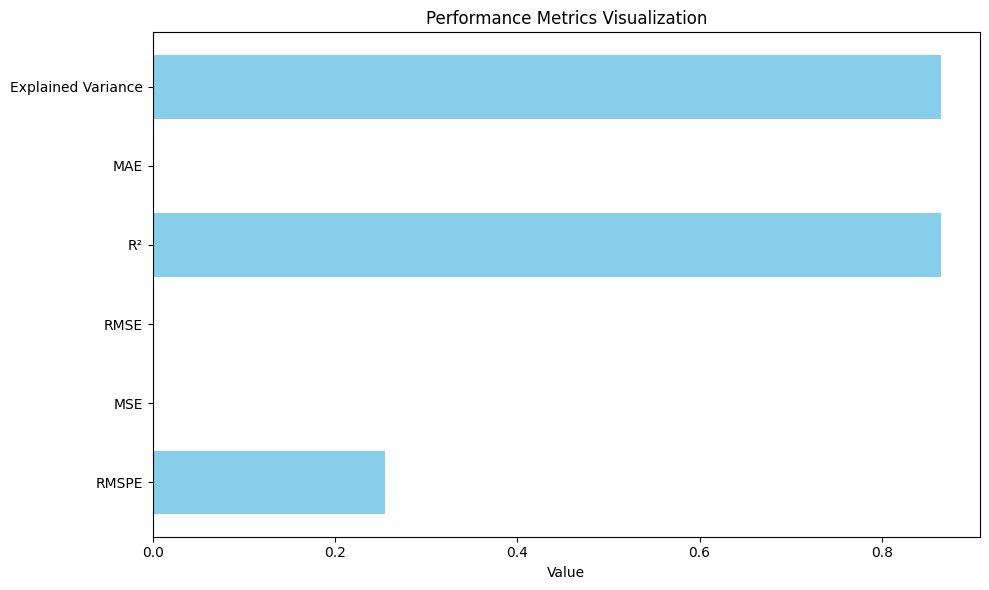

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Data
metrics = ['RMSPE', 'MSE', 'RMSE', 'R²', 'MAE', 'Explained Variance']
values = [0.255392, 0.000001, 0.001075, 0.864430, 0.000659, 0.864430]

# Create a DataFrame
df = pd.DataFrame({
    'Metric': metrics,
    'Value': values
})

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(df['Metric'], df['Value'], color='skyblue')
plt.xlabel('Value')
plt.title('Performance Metrics Visualization')
plt.tight_layout()

# Show plot
plt.show()
